In [1]:
# import sys
# print(sys.path)

['/geode2/home/u080/sheybani/BigRed200/github/transformprediction/models', '/N/soft/sles15/deeplearning/Python-3.10.2/lib/python310.zip', '/N/soft/sles15/deeplearning/Python-3.10.2/lib/python3.10', '/N/soft/sles15/deeplearning/Python-3.10.2/lib/python3.10/lib-dynload', '', '/N/soft/sles15/deeplearning/Python-3.10.2/lib/python3.10/site-packages']


In [1]:
# import torch
import os, re
import cv2
from tqdm import tqdm
import numpy as np
# import torchvision

In [2]:
def center_crop(image, crop_size):
    center = np.array(image.shape) / 2
    x = center[1] - crop_size/2
    y = center[0] - crop_size/2

    crop_img = image[int(y):int(y+crop_size), int(x):int(x+crop_size), :]
    return crop_img

In [3]:
vid_root = r"/N/slate/sheybani/ego4ddata/v1/clips/"
out_root = r"/N/slate/sheybani/ego4ddata/pp_images/"
sample_paths = os.listdir(vid_root)

for i,item in enumerate(sample_paths):
    suffix = item.split('.')[1]
    if (suffix !='mp4') and (suffix !='MP4'):
        del sample_paths[i]

In [14]:
# import json
# import pandas as pd
# with open('/N/slate/sheybani/ego4ddata/ego4d.json', 'r') as f:
#     metadata = json.loads(f.read())

# df = pd.DataFrame(metadata['videos'])
# df2 = df[df['split_fho']=='train']

# np.any(df['video_uid']=='be594565-b422-4ebd-8ef7-25b934a4640b')

In [5]:
# ds_rate = 15
new_fps = 5
crop_size= 256

start_sample = 0
end_sample = 100
for i in tqdm(range(start_sample, end_sample)):
    clip_name = sample_paths[i]
    new_dir = clip_name.split('.')[0]
#     new_dir = re.sub(r'\W+', '', new_dir) #remove non-alphanumeric characters
    try:
        chunks_dir = os.path.join(out_root, new_dir)
        os.mkdir(chunks_dir)
    except OSError as error: 
        print(error)
        
    fnum_o = 0
    fnum_n = 0
    vidcap = cv2.VideoCapture(vid_root+clip_name)
    orig_fps = vidcap.get(cv2.CAP_PROP_FPS)
    ds_rate = int(orig_fps/new_fps)
    while vidcap.isOpened():
        ret, frame = vidcap.read()
        if ret: 
            w,h,_ = frame.shape
            s_factor = crop_size/min(w,h)
            frame = cv2.resize(frame, None, fx=s_factor, fy=s_factor, interpolation= cv2.INTER_CUBIC)
            frame = center_crop(frame, crop_size)
            fname = os.path.join(chunks_dir, '{:d}.jpg'.format(fnum_n))
            cv2.imwrite(fname, frame)
            fnum_o += ds_rate 
            vidcap.set(cv2.CAP_PROP_POS_FRAMES, fnum_o)
            fnum_n +=1
        else:
            vidcap.release()
            break
#     fnum_o +=1

100%|█████████████████████████████████████████████| 2/2 [02:28<00:00, 74.10s/it]


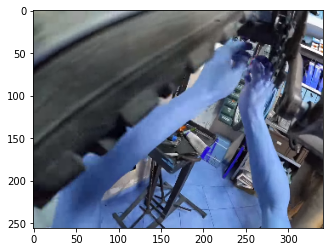

In [53]:
# import matplotlib.pyplot as plt
# plt.imshow(resize_down)

In [12]:
clip_name = sample_paths[10]
vidcap = cv2.VideoCapture(vid_root+clip_name)
print(vidcap.get(cv2.CAP_PROP_FPS))

30.0


# Check the Results

In [8]:
from torchvision.transforms import ToTensor, Normalize, ConvertImageDtype
from torch import nn
import os
import random
import matplotlib.pyplot as plt

vid_root = '/N/slate/sheybani/ego4ddata/pp_images/'

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'get', 'getBackendName', 'getExceptionMode', 'grab', 'isOpened', 'open', 'read', 'release', 'retrieve', 'set', 'setExceptionMode']


In [ ]:
# fnames = os.listdir(vid_root)
fnames = []
for froot, _, fname in os.walk(vid_root):
    if len(fname)>0:
        new_names = [os.path.join(froot,item) for item in fname]
        fnames +=new_names
# def get_picnum(fpath):
#     return int(fpath.split('/')[-1].split('.')[0])
fnames.sort()#key=get_picnum)

In [ ]:
# Create a Dataloader for the Time contrastive loss.
s_rate = 2

mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
transforms_ego4d = nn.Sequential(
    ConvertImageDtype(torch.float32),
    Normalize(mean,std),
    )
#     [
#      NormalizeVideo(mean, std),
#      Lambda(lambda x: torch.permute(x, (1,2,3,0)))
#      ])


class TimeContrastiveTorchDataset(torch.utils.data.Dataset):
    def __init__(self, fnames, pdif=1, ndif=5*s_rate, transform=None):
#         self.root = root
        self.fnames = fnames
        self.transform = transform
        self.pdif = pdif
        self.ndif = ndif #depends on the activity (perhaps some inherent period of the chore being done) 
        # 5*s_rate seems like a good number for the activities in ego4d
        
    def __getitem__(self, idx):
        # assuming idx is an int
        anchor_path = self.fnames[idx]
        pos_path = self.fnames[idx-self.pdif] # has an incorrect edge case at idx being the first in the folder,
        # which happens very rarely given that there are ~500 images in each folder
#         neg_path = random.choice(self.fnames)
        neg_path = self.fnames[idx-self.ndif]
        
        a = torchvision.io.read_image(anchor_path)
        p = torchvision.io.read_image(pos_path)
        n = torchvision.io.read_image(neg_path)
        
        if self.transform is not None:
            a,p,n = self.transform(a), self.transform(p), self.transform(n)
        return a,p,n
    
    def __len__(self):
        return len(self.fnames)

train_data = fnames
train_data_te = TimeContrastiveTorchDataset(train_data, pdif=2,
                                transform=transforms_ego4d)
train_dataloader = torch.utils.data.DataLoader(
    train_data_te, batch_size=8, shuffle=True, pin_memory=True) #num_workers=3

In [ ]:
for xtt in train_dataloader:
    break
fig,ax = plt.subplots(8,3, figsize=(9,20))
for i in range(3):
    for j in range(8):
        ax[j,i].imshow(torch.permute(xtt[i][j,...], (1,2,0)))

In [ ]:
fig,ax = plt.subplots(1,8, figsize=(20,7))
j = np.random.randint(len(train_data_te))
for i in range(8):
    xtt = torchvision.io.read_image(fnames[j+i])
    ax[i].imshow(torch.permute(xtt, (1,2,0)))